In [1]:
!pip install yfinance
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Downloading the data using yfinance API

In [3]:
tickers = ["BTC-USD","ETH-USD","ETC-USD"]
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,1,1)
data = yf.download(tickers,start=start,end = end, interval='1d')['Close']
#data.dropna(inplace=True)
data.head()

[*********************100%***********************]  3 of 3 completed


,BTC-USD,ETC-USD,ETH-USD
Date,,,
2020-01-01,7200.174316,4.502792,130.802002
2020-01-02,6985.470215,4.255888,127.410179
2020-01-03,7344.884277,4.576237,134.171707
2020-01-04,7410.656738,4.726842,135.069366
2020-01-05,7411.317383,4.907899,136.276779


In [4]:
data = data.rename({'BTC-USD':'BTC'}, axis='columns')
data = data.rename({'ETC-USD':'ETC'}, axis='columns')
data = data.rename({'ETH-USD':'ETH'}, axis='columns')

In [5]:
len(data)

732

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BTC,732.0,29276.996423,19677.885222,4970.788086,9720.034912,29187.936523,47729.456055,67566.828125
ETC,732.0,24.321442,24.554890,3.963946,6.160748,8.571023,47.734965,134.101791
ETH,732.0,1544.302857,1437.031209,110.605873,244.990406,744.711182,2636.036499,4812.087402


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2020-01-01 to 2022-01-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BTC     732 non-null    float64
 1   ETC     732 non-null    float64
 2   ETH     732 non-null    float64
dtypes: float64(3)
memory usage: 22.9 KB


There are no NULL values in the data.

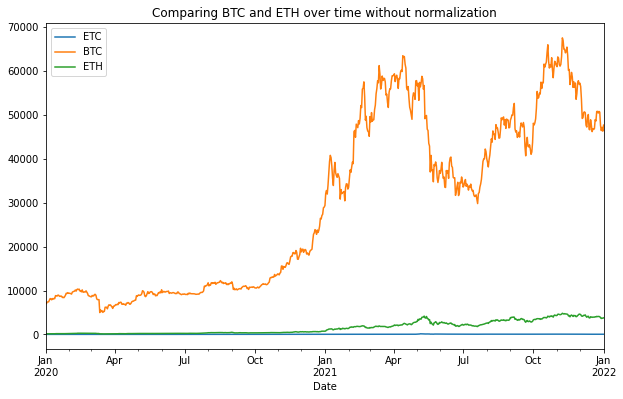

In [8]:
# Plotting before normalization

plt.figure(figsize=(10, 6))
data['ETC'].plot()
data['BTC'].plot()
data['ETH'].plot()
plt.legend(['ETC','BTC','ETH'])
_ = plt.title('Comparing BTC and ETH over time without normalization')
plt.show()

The above plot doesn't dipict the trend properly, because of difference in y-axix values. Lets check the trend by normalizing the data.

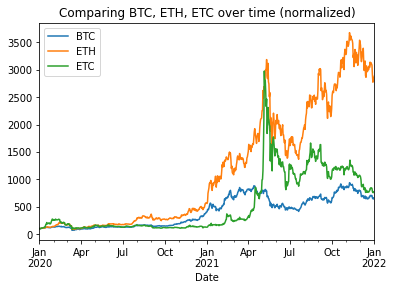

In [9]:
# Normalizing and comparison
# Both coins start from 100
normalized_btc = data.BTC.div(data.BTC.iloc[0]).mul(100)
normalized_eth = data.ETH.div(data.ETH.iloc[0]).mul(100)
normalized_etc = data.ETC.div(data.ETC.iloc[0]).mul(100)
normalized_btc.plot()
normalized_eth.plot()
normalized_etc.plot()
_ = plt.title('Comparing BTC, ETH, ETC over time (normalized)')
plt.legend(['BTC','ETH','ETC'])
plt.show()

The trends of Bitcoin and Ethereum are are very similar. Ethereum classic also has similar trend pattern, except for the last one year.
Data doesn't look startionary for any of the three crypto's.

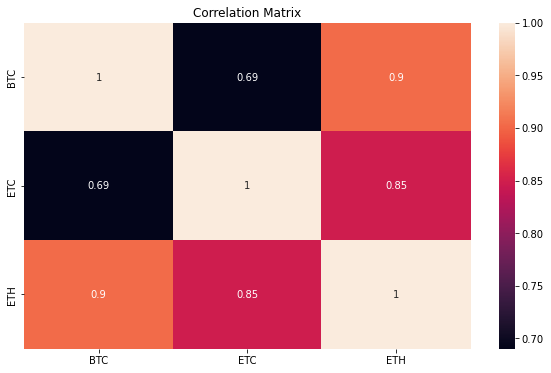

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

There is very high positive correlation between crypto currencies. As expected based on the trend patterns, Bitcoin and Ethereum are very highly correlated.

In [11]:
returns = data.pct_change()
returns.dropna(inplace=True)
returns.head()

,BTC,ETC,ETH
Date,,,
2020-01-02,-0.029819,-0.054834,-0.025931
2020-01-03,0.051452,0.075272,0.053069
2020-01-04,0.008955,0.032910,0.006690
2020-01-05,0.000089,0.038304,0.008939
2020-01-06,0.048291,0.028163,0.058905


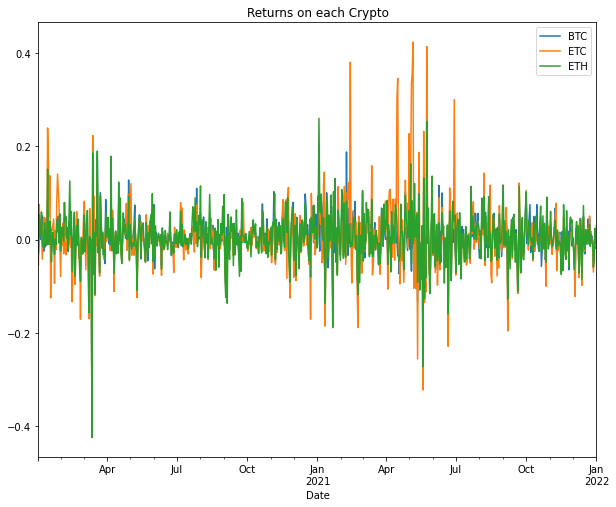

In [12]:
returns.plot(figsize=(10,8))
plt.title("Returns on each Crypto")
plt.show()

The returns for all crypto's followed same pattern and almost overlapped. Meaning the expected returns are very similar.

How correlated are Bitcoin and Ethereum?

In [13]:
import statsmodels.api as sm
y = returns['BTC']
X = returns['ETH']
X = sm.add_constant(X, prepend=False)
est_btc = sm.OLS(y, X)
model_btc = est_btc.fit()
model_btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BTC   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1253.
Date:                Wed, 30 Mar 2022   Prob (F-statistic):          1.61e-160
Time:                        23:13:26   Log-Likelihood:                 1682.6
No. Observations:                 731   AIC:                            -3361.
Df Residuals:                     729   BIC:                            -3352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ETH            0.6022      0.017     35.403      0.000       0.569       0.636
const         -0.0002      0.001     -0.251      0.802      -0.002       0.002
==============================================================================
Omnibus:                       79.649   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              587.684
Skew:                           0.046   Prob(JB):                    2.43e-128
Kurtosis:                       7.392   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model results indicate that p-value is 0, which means the coefficient is significant. And it explains 63% of the variance in the data. We can say that BTC and ETH are cointegrated.

How correlated are Ethereum and Ethereum classic?

In [14]:
y = returns['ETH']
X = returns['ETC']
X = sm.add_constant(X, prepend=False)
est_eth = sm.OLS(y, X)
model_eth = est_eth.fit()
model_eth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ETH   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     612.4
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.28e-98
Time:                        23:13:26   Log-Likelihood:                 1336.7
No. Observations:                 731   AIC:                            -2669.
Df Residuals:                     729   BIC:                            -2660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ETC            0.5217      0.021     24.747      0.000       0.480       0.563
const          0.0034      0.001      2.354      0.019       0.001       0.006
==============================================================================
Omnibus:                      222.314   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1983.313
Skew:                          -1.100   Prob(JB):                         0.00
Kurtosis:                      10.764   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the model results we can say that the coefficient is significant as the p value is zero. R- square is 0.457 which means it independent variable explains 45.7% of the variance in dependent variable.

# Stationarity Check

Auto Correlation Plot

<Figure size 720x432 with 0 Axes>

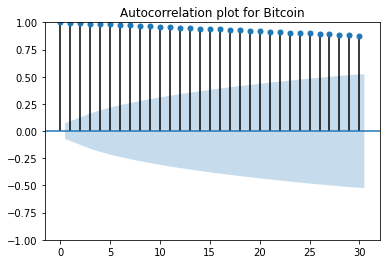

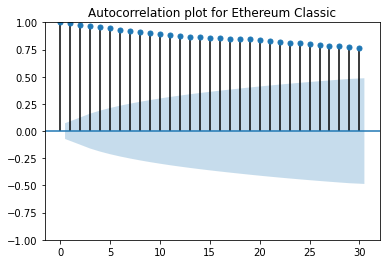

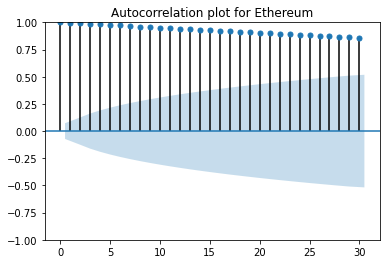

In [15]:
fig = plt.figure(figsize= (10,6))

sm.graphics.tsa.plot_acf(data['BTC'],lags=30, title='Autocorrelation plot for Bitcoin')
sm.graphics.tsa.plot_acf(data['ETC'],lags=30, title='Autocorrelation plot for Ethereum Classic')
sm.graphics.tsa.plot_acf(data['ETH'],lags=30, title='Autocorrelation plot for Ethereum')
plt.show()

There is gradual decay between the lags, which means the data is not stationary.

Partial Auto-Correlation Plot

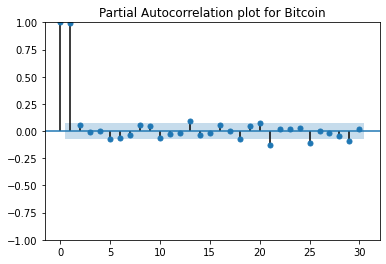

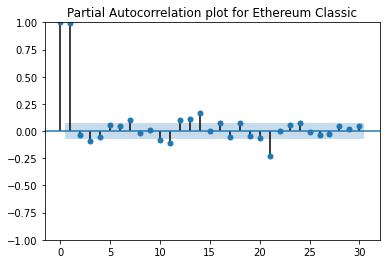

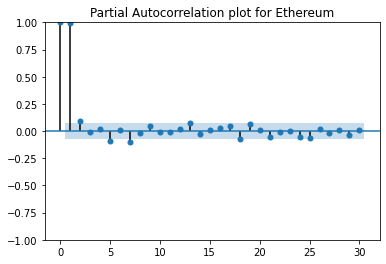

In [16]:
sm.graphics.tsa.plot_pacf(data['BTC'], lags=30, title='Partial Autocorrelation plot for Bitcoin')
sm.graphics.tsa.plot_pacf(data['ETC'], lags=30, title='Partial Autocorrelation plot for Ethereum Classic')
sm.graphics.tsa.plot_pacf(data['ETH'], lags=30, title='Partial Autocorrelation plot for Ethereum')
plt.show()

Partial auto correlation graph also confirms that the data is not stationary.

In [17]:
p_value_btc , p_value_etc, p_value_eth = adfuller(data['BTC'])[1], adfuller(data['ETC'])[1], adfuller(data['ETH'])[1]
print("The p-value of ADF test for BTC {}".format(p_value_btc))
print("The p-value of ADF test for ETC {}".format(p_value_etc))
print("The p-value of ADF test for ETH {}".format(p_value_eth))

The p-value of ADF test for BTC 0.735415936156147
The p-value of ADF test for ETC 0.3851250104462015
The p-value of ADF test for ETH 0.9186063064975907


P values are very high, so we fail reject the Null hypothesis. That means that the data is not stationary.

Taking the difference to make it stationary. Stationary data can be approximated using ARIMA model.

In [18]:
diff_data = data.diff().dropna()
diff_data.head()

,BTC,ETC,ETH
Date,,,
2020-01-02,-214.704102,-0.246904,-3.391823
2020-01-03,359.414062,0.320349,6.761528
2020-01-04,65.772461,0.150605,0.897659
2020-01-05,0.660645,0.181057,1.207413
2020-01-06,357.901855,0.138220,8.027374


Checking stationarity using partial auto correlation plot.

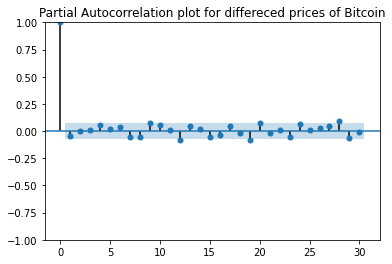

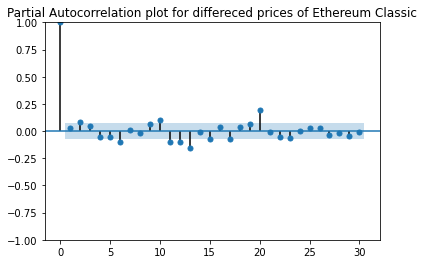

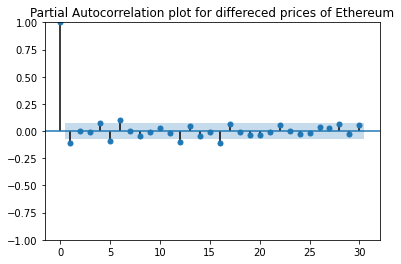

In [19]:
sm.graphics.tsa.plot_pacf(diff_data['BTC'], lags=30, title='Partial Autocorrelation plot for differeced prices of Bitcoin')
sm.graphics.tsa.plot_pacf(diff_data['ETC'], lags=30, title='Partial Autocorrelation plot for differeced prices of Ethereum Classic')
sm.graphics.tsa.plot_pacf(diff_data['ETH'], lags=30, title='Partial Autocorrelation plot for differeced prices of Ethereum')
plt.show()

There is sudden decay in the lags. Which indicates taht the data is stationary. We can confirm the stationarity using augmented Dickey–Fuller test below.

In [20]:
p_value_btc , p_value_etc, p_value_eth = adfuller(diff_data['BTC'])[1], adfuller(diff_data['ETC'])[1], adfuller(diff_data['ETH'])[1]
print("The p-value of ADF test for BTC {}".format(round(p_value_btc,5),'f'))
print("The p-value of ADF test for ETC {}".format(round(p_value_etc,5),'f'))
print("The p-value of ADF test for ETH {}".format(round(p_value_eth,5),'f'))

The p-value of ADF test for BTC 0.0
The p-value of ADF test for ETC 0.0
The p-value of ADF test for ETH 0.0


ADF test confirms the stationarity of the data. The p-values are very low, so we reject the NULL hypothesis, and confirm that the data is stationary.

In [21]:
def plot_decomposition(data_crympto):
    from statsmodels.tsa.seasonal import STL
    decomposition = STL(data_crympto, seasonal = 13)

    res = decomposition.fit()
    fig = res.plot()

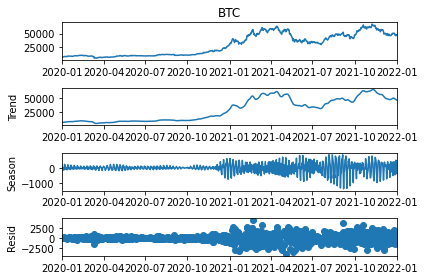

In [22]:
plot_decomposition(data['BTC'])

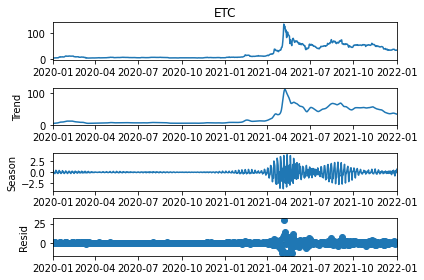

In [23]:
plot_decomposition(data['ETC'])

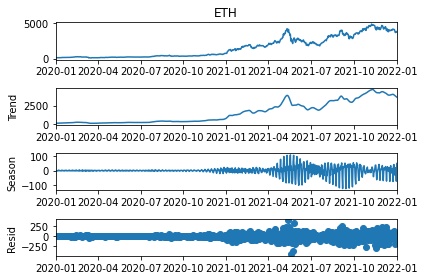

In [24]:
plot_decomposition(data['ETH'])

There is no seasonal behaviour in the crypto prices as observed from the decomposition plot.

# Time Series Prediction using ARIMA

In [25]:
size = int(len(data)*0.8)
df_train, df_test = data.iloc[:size], data.iloc[size:]

Hyperparameter tuning

In [26]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

def determinePDQ(data_df):
    p=q=range(0,6)
    d=range(0,3)
    pdq=list(itertools.product(p,d,q))
    arima_results_blk=[]
    for param_set in pdq:
        try:
            arima_blk=ARIMA(data_df, order=param_set)
            arima_fitted_blk = arima_blk.fit()
            arima_results_blk.append(arima_fitted_blk.aic)
            print('=='*25)
            print('ARIMA parameters are:{} & AIC value is:{}'.format(param_set,  arima_fitted_blk.aic))
        except:
            continue
    print('**'*25)
    print('The Lowest AIC score is {:.4f} and the corresponding parameters are {}'.format(pd.DataFrame(arima_results_blk).where(pd.DataFrame(arima_results_blk).T.notnull().all()).min()[0],pdq[arima_results_blk.index(min(arima_results_blk))]))

In [27]:
determinePDQ(df_train['BTC'])

ARIMA parameters are:(0, 0, 0) & AIC value is:16234.578809925217
ARIMA parameters are:(0, 0, 1) & AIC value is:12351.389472773124
ARIMA parameters are:(0, 0, 2) & AIC value is:11984.742985357792
ARIMA parameters are:(0, 0, 3) & AIC value is:11576.498797936092
ARIMA parameters are:(0, 0, 4) & AIC value is:11149.90932259601
ARIMA parameters are:(0, 0, 5) & AIC value is:11375.516913626194
ARIMA parameters are:(0, 1, 0) & AIC value is:9998.506665074485
ARIMA parameters are:(0, 1, 1) & AIC value is:9998.071911133884
ARIMA parameters are:(0, 1, 2) & AIC value is:9994.378448081045
ARIMA parameters are:(0, 1, 3) & AIC value is:9995.414707791657
ARIMA parameters are:(0, 1, 4) & AIC value is:9996.695363888128
ARIMA parameters are:(0, 1, 5) & AIC value is:9998.72528819293
ARIMA parameters are:(0, 2, 0) & AIC value is:10425.112511640627
ARIMA parameters are:(0, 2, 1) & AIC value is:9993.076879953613
ARIMA parameters are:(0, 2, 2) & AIC value is:9993.183370102815
ARIMA parameters are:(0, 2, 3) & AI

In [28]:
model_arima_btc = ARIMA(df_train['BTC'], order=(4,2,3))
results_arima_btc = model_arima_btc.fit()
results_arima_btc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    BTC   No. Observations:                  585
Model:                 ARIMA(4, 2, 3)   Log Likelihood               -4978.795
Date:                Wed, 30 Mar 2022   AIC                           9973.590
Time:                        23:15:44   BIC                          10008.535
Sample:                    01-01-2020   HQIC                          9987.211
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5007      0.037    -13.602      0.000      -0.573      -0.429
ar.L2         -0.8775      0.039    -22.332      0.000      -0.954      -0.800
ar.L3          0.0564      0.039      1.457      0.145      -0.019       0.132
ar.L4          0.0881      0.033      2.661      0.008       0.023       0.153
ma.L1         -0.5468      0.017    -31.590      0.000      -0.581      -0.513
ma.L2          0.5170      0.020     25.343      0.000       0.477       0.557
ma.L3         -0.9662      0.021    -46.734      0.000      -1.007      -0.926
sigma2      1.691e+06   6.01e+04     28.149      0.000    1.57e+06    1.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               893.96
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              22.20   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Except for auto regressor lag 3 all the remaining coefficients are statistically significant at 5% confidence interval.

Text(0.5, 1.0, 'ARIMA Results - Bitcoin')

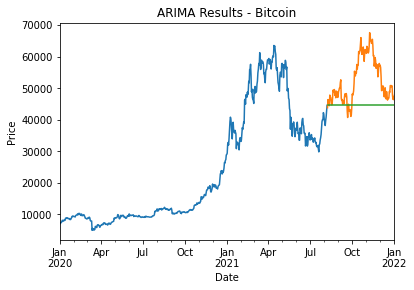

In [29]:
y_pred_btc_arima = pd.Series(results_arima_btc.forecast(len(df_test))[0],index=df_test.index)
df_test['BTC_PRED'] = y_pred_btc_arima.values
df_train['BTC'].plot()
df_test['BTC'].plot()
df_test['BTC_PRED'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Results - Bitcoin')

Text(0.5, 1.0, 'ARIMA Forecast - Bitcoin')

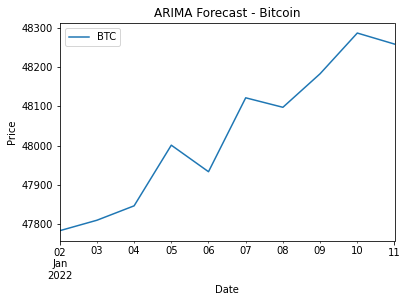

In [30]:
model_arima_btc = ARIMA(data['BTC'], order=(4,2,3))
results_arima_btc = model_arima_btc.fit()
forecast = results_arima_btc.forecast(steps=10)
df_forecast = pd.DataFrame(forecast)
df_forecast.columns = ['BTC']
df_forecast.plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast - Bitcoin')

Ethereum

In [31]:
determinePDQ(df_train['ETH'])

ARIMA parameters are:(0, 0, 0) & AIC value is:9700.139650594741
ARIMA parameters are:(0, 0, 1) & AIC value is:8997.4995160855
ARIMA parameters are:(0, 0, 2) & AIC value is:8805.64367284116
ARIMA parameters are:(0, 0, 3) & AIC value is:8137.054798245779
ARIMA parameters are:(0, 0, 4) & AIC value is:8543.815682747487
ARIMA parameters are:(0, 0, 5) & AIC value is:8093.826120515673
ARIMA parameters are:(0, 1, 0) & AIC value is:6920.256918273949
ARIMA parameters are:(0, 1, 1) & AIC value is:6910.995658704478
ARIMA parameters are:(0, 1, 2) & AIC value is:6897.451017803014
ARIMA parameters are:(0, 1, 3) & AIC value is:6899.163398468629
ARIMA parameters are:(0, 1, 4) & AIC value is:6900.962187954159
ARIMA parameters are:(0, 1, 5) & AIC value is:6900.923122220347
ARIMA parameters are:(0, 2, 0) & AIC value is:7394.5158910628425
ARIMA parameters are:(0, 2, 1) & AIC value is:6915.86810575898
ARIMA parameters are:(0, 2, 2) & AIC value is:6906.283272024949
ARIMA parameters are:(0, 2, 3) & AIC value 

In [32]:
model_arima_eth = ARIMA(df_train['ETH'], order=(3,2,5))
results_arima_eth = model_arima_eth.fit()
results_arima_eth.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ETH   No. Observations:                  585
Model:                 ARIMA(3, 2, 5)   Log Likelihood               -3415.246
Date:                Wed, 30 Mar 2022   AIC                           6848.492
Time:                        23:17:34   BIC                           6887.806
Sample:                    01-01-2020   HQIC                          6863.816
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2642      0.045    -28.397      0.000      -1.351      -1.177
ar.L2         -1.2304      0.051    -24.044      0.000      -1.331      -1.130
ar.L3         -0.6580      0.043    -15.283      0.000      -0.742      -0.574
ma.L1          0.1550      0.057      2.740      0.006       0.044       0.266
ma.L2          0.1683      0.042      3.978      0.000       0.085       0.251
ma.L3         -0.5066      0.048    -10.547      0.000      -0.601      -0.412
ma.L4         -0.6103      0.052    -11.716      0.000      -0.712      -0.508
ma.L5         -0.1933      0.028     -6.830      0.000      -0.249      -0.138
sigma2      7899.0684    205.195     38.495      0.000    7496.894    8301.242
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              8038.24
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             150.93   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the p-values all the lags are statistically significant.

Text(0.5, 1.0, 'ARIMA Results - Ethereum')

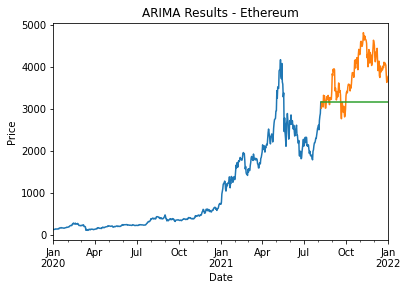

In [33]:
y_pred_eth_arima = pd.Series(results_arima_eth.forecast(len(df_test))[0],index=df_test.index)
df_test['ETH_PRED'] = y_pred_eth_arima.values
df_train['ETH'].plot()
df_test['ETH'].plot()
df_test['ETH_PRED'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Results - Ethereum')

Text(0.5, 1.0, 'ARIMA Forecast - Ethereum')

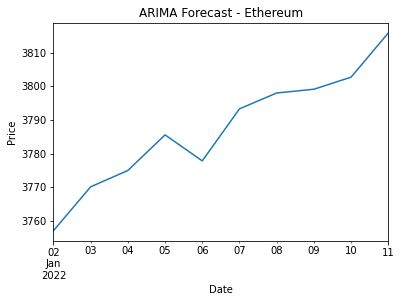

In [34]:
model_arima_eth = ARIMA(data['ETH'], order=(3,2,5))
results_arima_eth = model_arima_eth.fit()
forecast = results_arima_eth.forecast(steps=10)
df_forecast['ETH'] = pd.DataFrame(forecast)
df_forecast['ETH'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast - Ethereum')

Ethereum Classic

In [35]:
determinePDQ(df_train['ETC'])

ARIMA parameters are:(0, 0, 0) & AIC value is:5281.553405438421
ARIMA parameters are:(0, 0, 1) & AIC value is:4605.265078236978
ARIMA parameters are:(0, 0, 2) & AIC value is:4160.420404319133
ARIMA parameters are:(0, 0, 3) & AIC value is:3880.3877240027887
ARIMA parameters are:(0, 0, 4) & AIC value is:3687.921664420339
ARIMA parameters are:(0, 0, 5) & AIC value is:3566.2597710206064
ARIMA parameters are:(0, 1, 0) & AIC value is:3119.781148378136
ARIMA parameters are:(0, 1, 1) & AIC value is:3121.210687710065
ARIMA parameters are:(0, 1, 2) & AIC value is:3114.935228932315
ARIMA parameters are:(0, 1, 3) & AIC value is:3112.3692669052534
ARIMA parameters are:(0, 1, 4) & AIC value is:3113.9843628231515
ARIMA parameters are:(0, 1, 5) & AIC value is:3115.679621832945
ARIMA parameters are:(0, 2, 0) & AIC value is:3496.6565960822745
ARIMA parameters are:(0, 2, 1) & AIC value is:3123.407970504398
ARIMA parameters are:(0, 2, 2) & AIC value is:3124.772196377094
ARIMA parameters are:(0, 2, 3) & AI

In [36]:
model_arima_etc = ARIMA(df_train['ETC'], order=(5,1,5))
results_arima_etc = model_arima_etc.fit()
results_arima_etc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    ETC   No. Observations:                  585
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -1530.747
Date:                Wed, 30 Mar 2022   AIC                           3083.494
Time:                        23:19:22   BIC                           3131.563
Sample:                    01-01-2020   HQIC                          3102.229
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5884      0.115     -5.105      0.000      -0.814      -0.363
ar.L2         -0.2478      0.120     -2.068      0.039      -0.483      -0.013
ar.L3         -0.6209      0.067     -9.282      0.000      -0.752      -0.490
ar.L4         -0.3827      0.092     -4.169      0.000      -0.563      -0.203
ar.L5          0.2954      0.091      3.244      0.001       0.117       0.474
ma.L1          0.6010      0.124      4.846      0.000       0.358       0.844
ma.L2          0.3878      0.117      3.329      0.001       0.159       0.616
ma.L3          0.8605      0.073     11.843      0.000       0.718       1.003
ma.L4          0.5780      0.122      4.754      0.000       0.340       0.816
ma.L5         -0.1360      0.115     -1.186      0.235      -0.361       0.089
sigma2        11.0475      0.262     42.116      0.000      10.533      11.562
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             40562.76
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              98.04   Skew:                             1.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Except for the moving average lag 5, all the remaining lags are statistically significant.

Text(0.5, 1.0, 'ARIMA Results - Ethereum Classic')

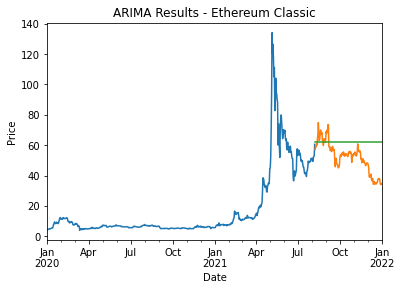

In [37]:
y_pred_etc_arima = pd.Series(results_arima_etc.forecast(len(df_test))[0],index=df_test.index)
df_test['ETC_PRED'] = y_pred_etc_arima.values
df_train['ETC'].plot()
df_test['ETC'].plot()
df_test['ETC_PRED'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Results - Ethereum Classic')

Text(0.5, 1.0, 'ARIMA Forecast - Ethereum Classic')

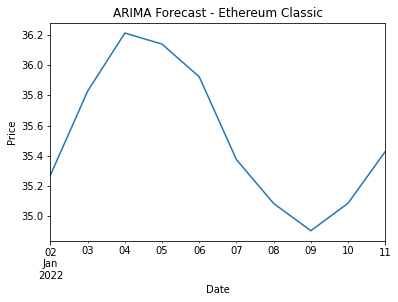

In [38]:
model_arima_etc = ARIMA(data['ETC'], order=(5,1,5))
results_arima_etc = model_arima_etc.fit()
forecast = results_arima_etc.forecast(steps=10)
df_forecast['ETC'] = pd.DataFrame(forecast)
df_forecast['ETC'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast - Ethereum Classic')

### BITCOIN time series prediction using LSTM

Due to the sequential nature of historical financial data from stocks or cryptocurrency, LSTM is an ideal technique for extracting acceptable patterns for modeling and prediction.Long-Short Term Memory (LSTM) is a form of RNN that allows us to analyze large sequences of data as well as single data points . They're effective for forecasting time series.

In [39]:
data.head()

,BTC,ETC,ETH
Date,,,
2020-01-01,7200.174316,4.502792,130.802002
2020-01-02,6985.470215,4.255888,127.410179
2020-01-03,7344.884277,4.576237,134.171707
2020-01-04,7410.656738,4.726842,135.069366
2020-01-05,7411.317383,4.907899,136.276779


In [40]:
btc_df = data[['BTC']]

In [41]:
btc_df.head()

,BTC
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [42]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math

In [43]:
#Normalizing the data
btc_data = btc_df.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(btc_data)
print(scaled_data.shape)


(732, 1)


In [44]:
# creating train data
training_size = math.ceil(len(btc_data) * .8)



train_data = scaled_data[0:training_size, :]

# Split the data itno x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])



In [45]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(526, 60, 1)

In [46]:
#creating test data

test_data = scaled_data[training_size - 60: , :]

# Split the data sets into x_test and y_test
x_test = []
y_test = scaled_data[training_size: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# convert data to numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [47]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [48]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=5, epochs=50)

Epoch 1/50
106/106 [==============================] - 9s 43ms/step - loss: 0.0106
Epoch 2/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0025
Epoch 3/50
106/106 [==============================] - 4s 41ms/step - loss: 0.0027
Epoch 4/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0023
Epoch 5/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0020
Epoch 6/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0015
Epoch 7/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0015
Epoch 8/50
106/106 [==============================] - 5s 44ms/step - loss: 0.0013
Epoch 9/50
106/106 [==============================] - 5s 45ms/step - loss: 0.0014
Epoch 10/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0011
Epoch 11/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0010
Epoch 12/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0011
Epoch 13/50
1

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean square error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )


In [51]:
# original = pd.DataFrame(scaler.inverse_transform(y_test))
original = scaler.inverse_transform(y_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
print("Test data RMSE: ", math.sqrt(mean_squared_error(original,predictions)))
print("Test data MAE: ", mean_absolute_error(original,predictions))
print("Test data R2 score:", r2_score(original, predictions))


Test data RMSE:  1867.808582285487
Test data MAE:  1487.4262093321918
Test data R2 score: 0.9260554938234371


RMSE gives the differences between predicted and true values.And , R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable.

[]

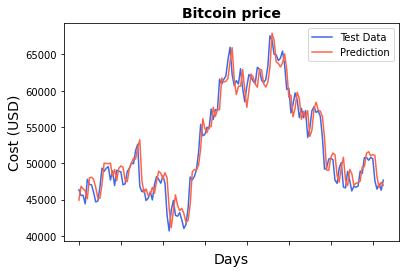

In [52]:

original_df = pd.DataFrame(scaler.inverse_transform(y_test))
predictions_df = pd.DataFrame(scaler.inverse_transform(model.predict(x_test)))

ax = sns.lineplot(x=original_df.index, y=original_df[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions_df.index, y=predictions_df[0], label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

We above compared the validation and training loss where:

1) Validation loss indicates how well the model fits new data.

2) Training loss indicates how well the model fits the training data.

 It depicts that both the losses have similar trend and that the model did an excellent job of fitting both the training and the test datasets.

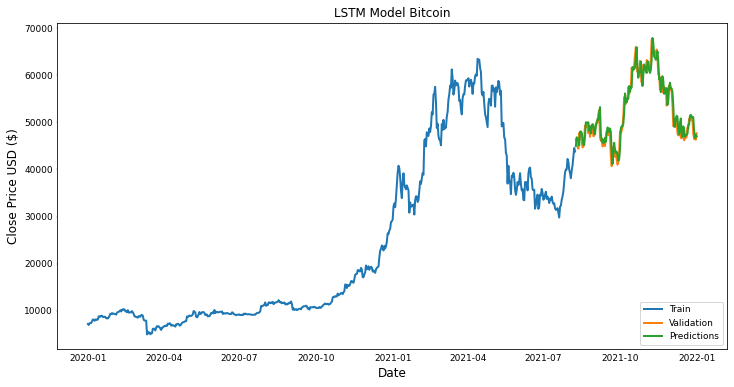

In [53]:
# Plot the data
train = btc_df[:training_size]
valid = btc_df[training_size:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(12,6))
plt.title('LSTM Model Bitcoin', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)

plt.plot(train['BTC'], linewidth=2.0)
plt.plot(valid[['BTC', 'Predictions']], linewidth=2.0)
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right', fontsize=9)
plt.show()

 The above line chart evaluates those predictions to our test data.It is quite clear that We see that the prediction line (green line) for Bitcoin is aligned with the the test results which implies that the model perfomed better.



In [54]:
import pandas_datareader as web
import datetime
# Get the quote
tickers = ["BTC-USD"]
start = datetime.datetime(2022,1,1)
end = datetime.datetime(2022,3,29)
btc_quote = yf.download("BTC-USD",start=start,end = end, interval='1d')

# btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start='2018-01-01', end='2021-09-20')
# Create a new dataframe
new_df = btc_quote.filter(['Close'])

# Get the last 60 days closing price
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# convert to numpy array
X_test = np.array(X_test)
# Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)[0]
# btc_quote2 = web.DataReader('BTC-USD', data_source='yahoo', start='2021-09-20', end='2021-09-20')
start1 = datetime.datetime(2022,3,29)
end1 = datetime.datetime(2022,3,29)
btc_quote2 = yf.download(tickers,start=start1,end = end1, interval='1d')

actual_price = btc_quote2['Close'][0]
actual_price
percent_change = ((pred_price-actual_price)/actual_price)*100
print('Prediction close price at 3-29-2022: $', pred_price, sep='')
print('Actual price at 3-29-2022: $', actual_price, sep='')
print('Percent Change: ', percent_change, '%', sep='')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Prediction close price at 3-29-2022: $[48241.004]
Actual price at 3-29-2022: $47465.73046875
Percent Change: [1.6333331]%


The above shows actual price from the yfinance and predicted price from the model which is pretty much similar.

## ETC time series using LSTM

In [85]:
data.head()

,BTC,ETC,ETH
Date,,,
2020-01-01,7200.174316,4.502792,130.802002
2020-01-02,6985.470215,4.255888,127.410179
2020-01-03,7344.884277,4.576237,134.171707
2020-01-04,7410.656738,4.726842,135.069366
2020-01-05,7411.317383,4.907899,136.276779


In [86]:
etc_df = data[['ETC']]

In [87]:
etc_df.head()

,ETC
Date,
2020-01-01,4.502792
2020-01-02,4.255888
2020-01-03,4.576237
2020-01-04,4.726842
2020-01-05,4.907899


In [88]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math

In [89]:
#Normalizing the data
etc_data = etc_df.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data_etc = scaler.fit_transform(etc_data)
print(scaled_data_etc.shape)


(732, 1)


In [90]:
# creating train data
training_size = math.ceil(len(etc_data) * .8)



train_data_etc = scaled_data_etc[0:training_size, :]

# Split the data itno x_train and y_train data sets
x_train_etc = []
y_train_etc = []

for i in range(60, len(train_data_etc)):
    x_train_etc.append(train_data_etc[i-60:i,0])
    y_train_etc.append(train_data_etc[i,0])



In [91]:
# Convert the x_train and y_train to numpy arrays
x_train_etc, y_train_etc = np.array(x_train_etc), np.array(y_train_etc)
# Reshape the data
x_train_etc = np.reshape(x_train_etc, (x_train_etc.shape[0], x_train_etc.shape[1], 1))
x_train_etc.shape

(526, 60, 1)

In [92]:
#creating test data

test_data_etc = scaled_data_etc[training_size - 60: , :]

# Split the data sets into x_test and y_test
x_test_etc = []
y_test_etc = scaled_data_etc[training_size: , :]
for i in range(60, len(test_data_etc)):
    x_test_etc.append(test_data_etc[i-60:i, 0])
    
# convert data to numpy array
x_test_etc = np.array(x_test_etc)

# reshape the data
x_test_etc = np.reshape(x_test_etc, (x_test_etc.shape[0], x_test_etc.shape[1], 1))

In [93]:
# Build the LSTM Model
model_etc = Sequential()
model_etc.add(LSTM(50, return_sequences=True, input_shape=(x_train_etc.shape[1], 1)))
model_etc.add(LSTM(50, return_sequences=False))
model_etc.add(Dense(25))
model_etc.add(Dense(1))

In [94]:
# Compile the model
model_etc.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_etc.fit(x_train_etc, y_train_etc, batch_size=5, epochs=50)

Epoch 1/50
106/106 [==============================] - 9s 43ms/step - loss: 0.0074
Epoch 2/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0040
Epoch 3/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0033
Epoch 4/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0026
Epoch 5/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0021
Epoch 6/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0022
Epoch 7/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0019
Epoch 8/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0016
Epoch 9/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0016
Epoch 10/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0016
Epoch 11/50
106/106 [==============================] - 4s 42ms/step - loss: 0.0013
Epoch 12/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0012
Epoch 13/50
1

In [95]:
# Get the models predicted price values
predictions_etc = model_etc.predict(x_test_etc)
predictions_etc = scaler.inverse_transform(predictions_etc)

# Get the root mean square error (RMSE)
rmse = np.sqrt( np.mean( predictions_etc - y_test_etc )**2 )


In [96]:
# original = pd.DataFrame(scaler.inverse_transform(y_test))
original_etc = scaler.inverse_transform(y_test_etc)
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_etc,predictions_etc)))
print("Test data MSE: ", mean_squared_error(original_etc,predictions_etc))
print("Test data MAE: ", mean_absolute_error(original_etc,predictions_etc))
print("Test data R2 score:", r2_score(original_etc, predictions_etc))


Test data RMSE:  2.637303323706319
Test data MSE:  6.955368821232397
Test data MAE:  1.8209592479549042
Test data R2 score: 0.9296387892932666


RMSE gives the differences between predicted and true values .And , R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable. 

[]

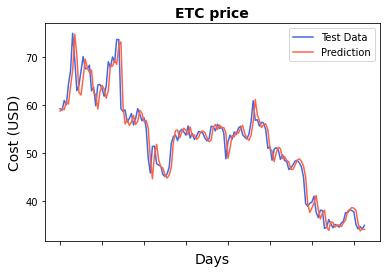

In [97]:

etc_original_df = pd.DataFrame(scaler.inverse_transform(y_test_etc))
etc_predictions_df = pd.DataFrame(scaler.inverse_transform(model_etc.predict(x_test_etc)))

ax = sns.lineplot(x=etc_original_df.index, y=etc_original_df[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=etc_predictions_df.index, y=etc_predictions_df[0], label="Prediction", color='tomato')
ax.set_title('ETC price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

We above compared the validation and training loss where:

1) Validation loss indicates how well the model fits new data.

2) Training loss indicates how well the model fits the training data.

 It depicts that both the losses have similar trend and that the model did an excellent job of fitting both the training and the test datasets.

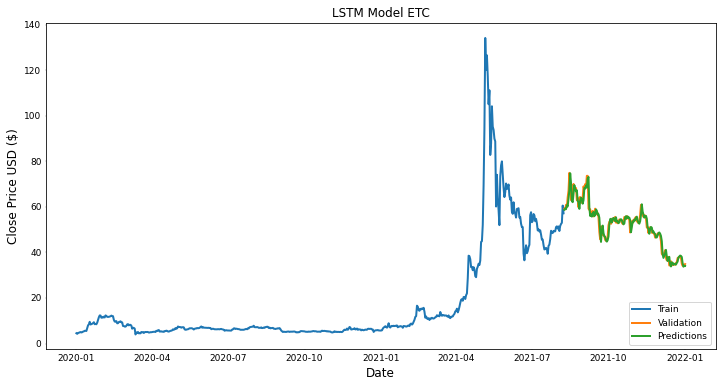

In [98]:
# Plot the data
train_etc = etc_df[:training_size]
valid_etc = etc_df[training_size:]
valid_etc['Predictions'] = predictions_etc

# Visualize the data
plt.figure(figsize=(12,6))
plt.title('LSTM Model ETC', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)

plt.plot(train_etc['ETC'], linewidth=2.0)
plt.plot(valid_etc[['ETC', 'Predictions']], linewidth=2.0)
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right', fontsize=9)
plt.show()

 The above line chart evaluates those predictions to our test data.It is quite clear that We see that the prediction line (green line) for ETC is aligned with the the test results which implies that the model perfomed better.

In [99]:
import pandas_datareader as web
# Get the quote
tickers = ["ETC-USD"]
start = datetime.datetime(2022,1,1)
end = datetime.datetime(2022,3,29)
etc_quote = yf.download("ETC-USD",start=start,end = end, interval='1d')

# btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start='2018-01-01', end='2021-09-20')
# Create a new dataframe
new_df = etc_quote.filter(['Close'])

# Get the last 60 days closing price
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# convert to numpy array
X_test = np.array(X_test)
# Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_etc.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)[0]
# btc_quote2 = web.DataReader('BTC-USD', data_source='yahoo', start='2021-09-20', end='2021-09-20')
start1 = datetime.datetime(2022,3,29)
end1 = datetime.datetime(2022,3,29)
etc_quote2 = yf.download(tickers,start=start1,end = end1, interval='1d')

actual_price = etc_quote2['Close'][0]
actual_price
percent_change = ((pred_price-actual_price)/actual_price)*100
print('Prediction close price at 3-29-2022: $', pred_price, sep='')
print('Actual price at 3-29-2022: $', actual_price, sep='')
print('Percent Change: ', percent_change, '%', sep='')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Prediction close price at 3-29-2022: $[49.42602]
Actual price at 3-29-2022: $49.309242248535156
Percent Change: [0.23683052]%



The above shows actual price from the yfinance and predicted price from the model which is pretty much similar. It assists us in predicting the market's future path and price.



# LSTM for ETH

In [70]:
data.head()

,BTC,ETC,ETH
Date,,,
2020-01-01,7200.174316,4.502792,130.802002
2020-01-02,6985.470215,4.255888,127.410179
2020-01-03,7344.884277,4.576237,134.171707
2020-01-04,7410.656738,4.726842,135.069366
2020-01-05,7411.317383,4.907899,136.276779


In [71]:
eth_df = data[['ETH']]

In [72]:
eth_df.head()

,ETH
Date,
2020-01-01,130.802002
2020-01-02,127.410179
2020-01-03,134.171707
2020-01-04,135.069366
2020-01-05,136.276779


In [73]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import math

In [74]:
#Normalizing the data
eth_data = eth_df.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data_eth = scaler.fit_transform(eth_data)
print(scaled_data_eth.shape)


(732, 1)


In [75]:
# creating train data
training_size = math.ceil(len(eth_data) * .8)



train_data_eth = scaled_data_eth[0:training_size, :]

# Split the data itno x_train and y_train data sets
x_train_eth = []
y_train_eth = []

for i in range(60, len(train_data_eth)):
    x_train_eth.append(train_data_eth[i-60:i,0])
    y_train_eth.append(train_data_eth[i,0])



In [76]:
# Convert the x_train and y_train to numpy arrays
x_train_eth, y_train_eth = np.array(x_train_eth), np.array(y_train_eth)
# Reshape the data
x_train_eth = np.reshape(x_train_eth, (x_train_eth.shape[0], x_train_eth.shape[1], 1))
x_train_eth.shape

(526, 60, 1)

In [77]:
#creating test data

test_data_eth = scaled_data_eth[training_size - 60: , :]

# Split the data sets into x_test and y_test
x_test_eth = []
y_test_eth = scaled_data_eth[training_size: , :]
for i in range(60, len(test_data_eth)):
    x_test_eth.append(test_data_eth[i-60:i, 0])
    
# convert data to numpy array
x_test_eth = np.array(x_test_eth)

# reshape the data
x_test_eth = np.reshape(x_test_eth, (x_test_eth.shape[0], x_test_eth.shape[1], 1))

In [78]:
# Build the LSTM Model
model_eth = Sequential()
model_eth.add(LSTM(50, return_sequences=True, input_shape=(x_train_eth.shape[1], 1)))
model_eth.add(LSTM(50, return_sequences=False))
model_eth.add(Dense(25))
model_eth.add(Dense(1))

In [79]:
# Compile the model
model_eth.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model_eth.fit(x_train_eth, y_train_eth, batch_size=5, epochs=50)

Epoch 1/50
106/106 [==============================] - 9s 44ms/step - loss: 0.0079
Epoch 2/50
106/106 [==============================] - 5s 44ms/step - loss: 0.0025
Epoch 3/50
106/106 [==============================] - 5s 44ms/step - loss: 0.0019
Epoch 4/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0015
Epoch 5/50
106/106 [==============================] - 5s 43ms/step - loss: 0.0013
Epoch 6/50
106/106 [==============================] - 5s 43ms/step - loss: 9.3031e-04
Epoch 7/50
106/106 [==============================] - 5s 44ms/step - loss: 0.0013
Epoch 8/50
106/106 [==============================] - 5s 43ms/step - loss: 9.6305e-04
Epoch 9/50
106/106 [==============================] - 5s 43ms/step - loss: 8.5864e-04
Epoch 10/50
106/106 [==============================] - 5s 43ms/step - loss: 7.6340e-04
Epoch 11/50
106/106 [==============================] - 5s 44ms/step - loss: 6.4128e-04
Epoch 12/50
106/106 [==============================] - 5s 43ms/step - loss: 

In [80]:
# Get the models predicted price values
predictions_eth = model_eth.predict(x_test_eth)
predictions_eth = scaler.inverse_transform(predictions_eth)

# Get the root mean square error (RMSE)
rmse = np.sqrt( np.mean( predictions_eth - y_test_eth )**2 )


In [81]:
# original = pd.DataFrame(scaler.inverse_transform(y_test))
original_eth = scaler.inverse_transform(y_test_eth)
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_eth,predictions_eth)))
print("Test data MAE: ", mean_absolute_error(original_eth,predictions_eth))
print("Test data R2 score:", r2_score(original_eth, predictions_eth))


Test data RMSE:  196.24113659120243
Test data MAE:  153.2859672650899
Test data R2 score: 0.8552841692991364


RMSE gives the differences between predicted and true values.And , R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable.

[]

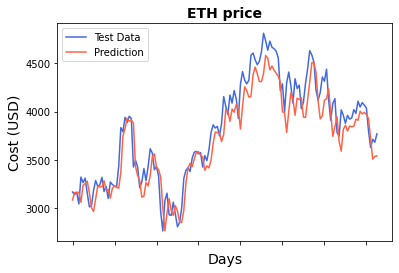

In [82]:

eth_original_df = pd.DataFrame(scaler.inverse_transform(y_test_eth))
eth_predictions_df = pd.DataFrame(scaler.inverse_transform(model_eth.predict(x_test_eth)))

ax = sns.lineplot(x=eth_original_df.index, y=eth_original_df[0], label="Test Data", color='royalblue')
ax = sns.lineplot(x=eth_predictions_df.index, y=eth_predictions_df[0], label="Prediction", color='tomato')
ax.set_title('ETH price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)

We above compared the validation and training loss where:

1) Validation loss indicates how well the model fits new data.

2) Training loss indicates how well the model fits the training data.

 It depicts that both the losses have similar trend and that the model did an excellent job of fitting both the training and the test datasets.

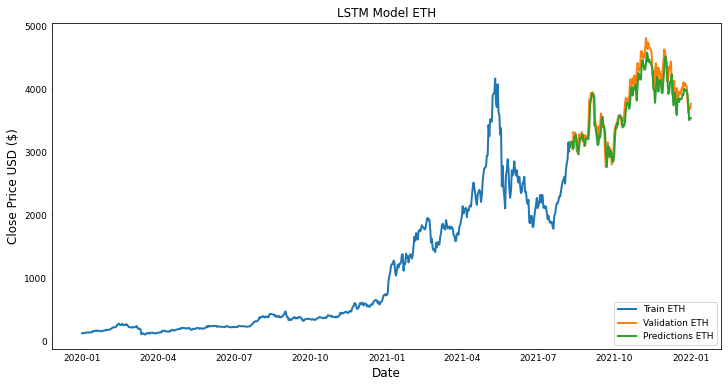

In [83]:
# Plot the data
train_eth = eth_df[:training_size]
valid_eth = eth_df[training_size:]
valid_eth['Predictions'] = predictions_eth

# Visualize the data
plt.figure(figsize=(12,6))
plt.title('LSTM Model ETH', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.tick_params(labelsize=9, width=0.2, length=1)

plt.plot(train_eth['ETH'], linewidth=2.0)
plt.plot(valid_eth[['ETH', 'Predictions']], linewidth=2.0)
plt.legend(['Train ETH', 'Validation ETH', 'Predictions ETH'], loc='lower right', fontsize=9)
plt.show()

The above line chart evaluates those predictions to our test data.It is quite clear that We see that the prediction line (green line) for ETH is aligned with the the test results which implies that the model perfomed better.


In [84]:
import pandas_datareader as web
# Get the quote
tickers = ["ETH-USD"]
start = datetime.datetime(2022,1,1)
end = datetime.datetime(2022,3,29)
eth_quote = yf.download("ETH-USD",start=start,end = end, interval='1d')

# btc_quote = web.DataReader('BTC-USD', data_source='yahoo', start='2018-01-01', end='2021-09-20')
# Create a new dataframe
new_df = eth_quote.filter(['Close'])

# Get the last 60 days closing price
last_60_days = new_df[-60:].values

# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# convert to numpy array
X_test = np.array(X_test)
# Reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_eth.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)[0]
# btc_quote2 = web.DataReader('BTC-USD', data_source='yahoo', start='2021-09-20', end='2021-09-20')
start1 = datetime.datetime(2022,3,29)
end1 = datetime.datetime(2022,3,29)
eth_quote2 = yf.download(tickers,start=start1,end = end1, interval='1d')

actual_price = eth_quote2['Close'][0]
actual_price
percent_change = ((pred_price-actual_price)/actual_price)*100
print('Prediction close price at 3-29-2022: $', pred_price, sep='')
print('Actual price at 3-29-2022: $', actual_price, sep='')
print('Percent Change: ', percent_change, '%', sep='')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Prediction close price at 3-29-2022: $[3386.8804]
Actual price at 3-29-2022: $3401.98779296875
Percent Change: [-0.4440763]%


The above shows actual price from the yfinance and predicted price from the model which is pretty much similar.It assists us in predicting the market's future path and price.